In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
import random
from sklearn.metrics import classification_report

# 1. Загрузка и обработка данных

In [3]:
# Подключение к базе данных
db_path = r"C:\Users\Evgeniya\OneDrive\Desktop\Домашняя\Итоговый проект аналитика\data\result_data\shop_database.db"
conn = sqlite3.connect(db_path)

In [4]:
# Получение списка таблиц
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)
tables

,name
0,purchases
1,personal_data_coeffs
2,personal_data


In [5]:
# Загрузка всех таблиц из базы данных
personal_data = pd.read_sql("SELECT * FROM personal_data", conn)
personal_data_coeffs = pd.read_sql("SELECT * FROM personal_data_coeffs", conn)
purchases = pd.read_sql("SELECT * FROM purchases", conn)


In [6]:
# Просмотр размеров загруженных таблиц
{
    "personal_data": personal_data.shape,
    "personal_data_coeffs": personal_data_coeffs.shape,
    "purchases": purchases.shape
}

{'personal_data': (89241, 6),
 'personal_data_coeffs': (104989, 5),
 'purchases': (786260, 7)}

In [7]:
personal_data.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [8]:
personal_data_coeffs.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [9]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [10]:
# Фильтрация клиентов из страны 32
personal_data_country_32 = personal_data[personal_data['country'] == 32]

In [11]:
# Объединение таблиц
merged_data = personal_data_country_32.merge(personal_data_coeffs, on='id', how='left')
full_data = merged_data.merge(purchases, on='id', how='left')

In [12]:
# Размер объединённого датафрейма
full_data.shape

(664665, 16)

In [13]:
full_data.head()

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,Стол Outventure,зелёный,1499,NaN,0,37
2,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,NaN,0,0
4,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,Шлем FILA NRK FUN,белый,4999,NaN,0,0


In [14]:
# смотрим пропуски 
full_data.isnull().sum()

id                    0
gender                0
age                   0
education             0
city                  0
country               0
lbt_coef              0
ac_coef               0
sm_coef               0
personal_coef         0
product               0
colour           101589
cost                  0
product_sex      266512
base_sale             0
dt                    0
dtype: int64

In [15]:
# Нормализация названий товаров (product)
full_data["product"] = (full_data["product"].str.lower().str.strip().str.replace(r"[^а-яa-z0-9\s]", "", regex=True))


In [16]:
# Нормализация цветов
full_data["colour"] = (full_data["colour"].str.lower().str.strip())


In [17]:
full_data.head()

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,велосипед горный женский stern mira 20 26,белый/синий,13599,0.0,1,7
1,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,NaN,0,37
2,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,набор outventure стол 4 стула,бежевый,4799,NaN,0,37
3,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный/розовый,9199,NaN,0,0
4,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,NaN,0,0


In [18]:
# в colour есть /. Разобрав предстоящие задачи, пришла к выводу, 
# что лучше оставить только первый цвет — это наилучший баланс между простотой и информативностью.
full_data["colour"] = (full_data["colour"].str.split("/").str[0])          


In [19]:
full_data

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,велосипед горный женский stern mira 20 26,белый,13599,0.0,1,7
1,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,NaN,0,37
2,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,набор outventure стол 4 стула,бежевый,4799,NaN,0,37
3,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный,9199,NaN,0,0
4,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664660,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,полуботинки мужские ascot vortex,хаки,7999,1.0,0,12
664661,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,кроссовки мужские nike air max 90,черный,24299,1.0,0,13
664662,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,кроссовки мужские nike air max 90,черный,24299,1.0,0,20
664663,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,пакет,коричневый,12,NaN,0,20


# 2. Построение бинарной классификации

In [21]:
train_df = full_data.copy()

In [22]:
full_data["gender"].unique()

array([0, 1], dtype=int64)

In [23]:
# Кодировка образования
le = LabelEncoder()
train_df["education_enc"] = le.fit_transform(train_df["education"])

In [24]:
# Признаки и целевая переменная
X = train_df[["age", "city", "personal_coef", "education_enc"]]
y = train_df["gender"]

In [25]:
# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [26]:
#  Обучение модели
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Оценка качества 
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1-score:", round(f1_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 4))

Accuracy: 1.0
F1-score: 1.0
ROC AUC: 1.0


In [28]:
# Загрузка потерянных данных (личных)
personal_data = pd.read_csv(r"C:\Users\Evgeniya\OneDrive\Desktop\Домашняя\Итоговый проект аналитика\personal_data.csv")
personal_data.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [29]:
personal_data.shape

(15748, 5)

In [30]:
personal_data = personal_data.rename(columns={"id": "client_id"})
personal_data_coeffs = personal_data_coeffs.rename(columns={"id": "client_id"})


In [31]:
personal_data = personal_data.merge(personal_data_coeffs[["client_id", "personal_coef"]], on="client_id", how="left")

In [32]:
personal_data["education_enc"] = le.transform(personal_data["education"])

In [33]:
personal_data.head()

,client_id,age,education,city,country,personal_coef,education_enc
0,101492,32,среднее,1188,32,0.4304,1
1,42690,20,высшее,1134,32,0.4688,0
2,113001,27,среднее,1187,32,0.4304,1
3,163654,49,высшее,1160,32,0.5584,0
4,69523,44,среднее,1137,32,0.5072,1


In [34]:
# Признаки
X_missing = personal_data[["age", "city", "personal_coef", "education_enc"]]

In [35]:
#  Предсказание 
predicted = clf.predict(X_missing)
personal_data["predicted_gender"] = predicted


In [36]:
personal_data.head()

,client_id,age,education,city,country,personal_coef,education_enc,predicted_gender
0,101492,32,среднее,1188,32,0.4304,1,1
1,42690,20,высшее,1134,32,0.4688,0,1
2,113001,27,среднее,1187,32,0.4304,1,1
3,163654,49,высшее,1160,32,0.5584,0,0
4,69523,44,среднее,1137,32,0.5072,1,0


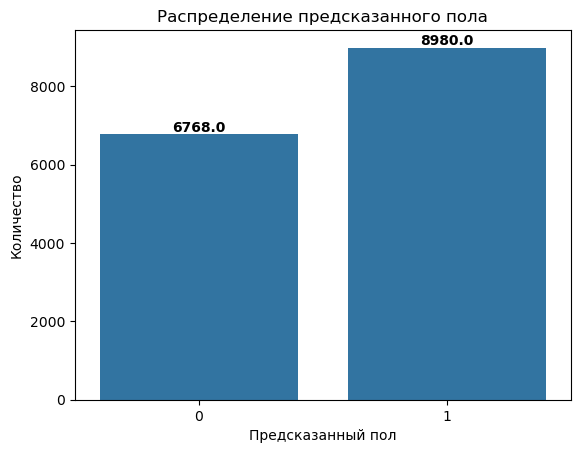

In [37]:
# Распределение предсказанного пола:

ax = sns.countplot(x="predicted_gender", data=personal_data)
plt.title("Распределение предсказанного пола")
plt.xlabel("Предсказанный пол")
plt.ylabel("Количество")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

# 3. A/B тестирование

In [39]:
# Отфильтруем данные по нужным дням кампании: с 5-го по 16-й день
campaign_period = full_data[(full_data["dt"] >= 5) & (full_data["dt"] <= 16)]
campaign_period

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,велосипед горный женский stern mira 20 26,белый,13599,0.0,1,7
12,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,футболка мужская kappa authentic core,темно-синий,999,1.0,0,8
13,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,бейсболка детская nike futura mash up,синий,1119,NaN,1,11
14,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,носки детские demix 2 пары,синий,299,NaN,0,11
15,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,кроссовки мужские adidas lite racer cln 20,черный,7399,1.0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664657,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,кроссовки мужские nike air max sc,серый,13999,1.0,0,6
664658,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,кроссовки мужские fila regen,None,5999,1.0,0,9
664659,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,жилет мужской icepeak manheim,None,8699,1.0,0,9
664660,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,полуботинки мужские ascot vortex,хаки,7999,1.0,0,12


In [40]:
# Чтение и извлечение ID

with open(r"C:\Users\Evgeniya\OneDrive\Desktop\Домашняя\Итоговый проект аналитика\data\result_data\ids_first_company_positive.txt", encoding="utf-8") as f:
    positive_ids = pd.DataFrame({"client_id": list(map(int, re.findall(r"\d+", f.read())))})
positive_ids["group"] = "A"

with open(r"C:\Users\Evgeniya\OneDrive\Desktop\Домашняя\Итоговый проект аналитика\data\result_data\ids_first_company_negative.txt", "r", encoding="utf-8") as f:
    negative_ids = pd.DataFrame({"client_id": list(map(int, re.findall(r"\d+", f.read())))})
negative_ids["group"] = "B"

In [41]:
# Объединяем группы
ab_test = pd.concat([positive_ids, negative_ids], ignore_index=True)
ab_test

,client_id,group
0,88128,A
1,171960,A
2,142117,A
3,114589,A
4,146123,A
...,...,...
10039,89121,B
10040,161445,B
10041,162570,B
10042,92547,B


In [42]:
# Признак факта покупки
ab_test["made_purchase"] = ab_test["client_id"].isin(campaign_period["id"]).astype(int)
ab_test.head()

,client_id,group,made_purchase
0,88128,A,1
1,171960,A,1
2,142117,A,1
3,114589,A,1
4,146123,A,1


In [43]:
# Подсчёт конверсий
conversion_stats = ab_test.groupby("group")["made_purchase"].agg(["count", "sum"])
conversion_stats["conversion_rate"] = (conversion_stats["sum"] / conversion_stats["count"]).round(2)
conversion_stats

,count,sum,conversion_rate
group,,,
A,5023,4063,0.81
B,5021,4199,0.84


In [44]:
conversion_stats["conversion_rate_percent"] = (conversion_stats["conversion_rate"] * 100).round(2)

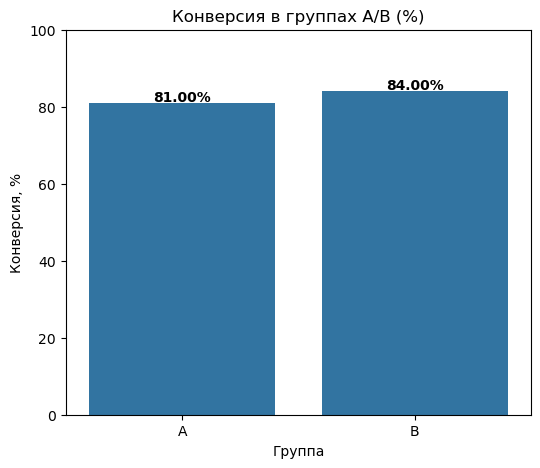

In [45]:
# Построение графика с подписями
plt.figure(figsize=(6, 5))
sns.barplot(x="group", y="conversion_rate_percent", data=conversion_stats)
plt.title("Конверсия в группах A/B (%)")
plt.ylabel("Конверсия, %")
plt.xlabel("Группа")

# Подписи над столбцами
for index, row in conversion_stats.iterrows():
    plt.text(index, row["conversion_rate_percent"] + 0.5, f'{row["conversion_rate_percent"]:.2f}%', 
             color='black', ha="center", fontweight='bold')

plt.ylim(0, 100)
plt.show()

In [46]:
# Расчет Z -статистики:
# Успехи (покупки)
successes = [4063, 4199]
# Размеры выборок
nobs = [5023, 5021]

In [47]:
# Z-тест
z_stat, p_val = proportions_ztest(count=successes, nobs=nobs, alternative='two-sided')
print (z_stat, p_val)

-3.5951570312320165 0.00032419596862596947


## Вывод: мы протестировали гипотезу:
 - H₀ (нулевая гипотеза): Конверсии в группах A и B равны;
 - H₁ (альтернатива): Конверсии различаются.

Z-статистика: −3.6
P-value: < 0.0001 

✅ Разница статистически значима — кампания A показала результат хуже, чем контрольная группа.


Группа	              Успехов (покупок)	   Всего клиентов	Конверсия
A (со скидкой)	           4063	              5023	         0.81
B (без скидки)	           4199	              5021	         0.84


 * P-value < 0.05 → мы отвергаем нулевую гипотезу;
 * Разница между группами статистически значима;
 * Группа без скидки (B) показала лучший результат неслучайно.

**Вывод:**
1. Предоставление персональной скидки не повысило, а снизило вероятность покупки.
2. С высокой долей вероятности — скидка воспринималась как лишняя, неуместная или подозрительная.
3. Кампания оказалась неэффективной и, возможно, даже вредной для выручки.

**Рекомендации:**
 - Остановить повторение email-скидок в текущем формате.
 - Протестировать другие виды стимулов:
                      Бонусы, подарки, лотереи;
 - Информирование, а не навязывание скидки.
 - Провести кластеризацию клиентов:
   Выявить группы, которым действительно нужны скидки;
   Предлагать персонализированные стимулы по сегментам.

# 4. Кластеризация

In [50]:
#  Переименуем столбцы в personal_data
personal_data.rename(columns={"client_id": "id", "predicted_gender": "gender"}, inplace=True)

In [51]:
# Удалим полностью пустые (все NaN) столбцы в personal_data перед объединением
personal_data_cleaned = personal_data.dropna(axis=1, how="all")

# Повторим выравнивание колонок
for col in full_data.columns:
    if col not in personal_data_cleaned.columns:
        personal_data_cleaned[col] = None

# Упорядочим колонки и объединим
personal_data_cleaned = personal_data_cleaned[full_data.columns]
full_data_all = pd.concat([full_data, personal_data_cleaned], ignore_index=True)
full_data_all.head()


C:\Users\Evgeniya\AppData\Local\Temp\ipykernel_9412\3064333198.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_data_all = pd.concat([full_data, personal_data_cleaned], ignore_index=True)


,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,велосипед горный женский stern mira 20 26,белый,13599,0.0,1,7
1,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,NaN,0,37
2,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,набор outventure стол 4 стула,бежевый,4799,NaN,0,37
3,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный,9199,NaN,0,0
4,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,NaN,0,0


In [52]:
full_data_all.shape

(680413, 16)

In [53]:
full_data_all.isnull().sum()

id                    0
gender                0
age                   0
education             0
city                  0
country               0
lbt_coef          15748
ac_coef           15748
sm_coef           15748
personal_coef         0
product           15748
colour           117337
cost              15748
product_sex      282260
base_sale         15748
dt                15748
dtype: int64

In [54]:
# Фильтрация нужных столбцов
columns_to_keep = ["id", "gender", "age", "education", "city", "country", "personal_coef", "product", "cost", "base_sale", "dt"]
data_all = full_data_all[columns_to_keep].copy()
data_all

,id,gender,age,education,city,country,personal_coef,product,cost,base_sale,dt
0,0,0,36,среднее,1201,32,0.5072,велосипед горный женский stern mira 20 26,13599,1,7
1,0,0,36,среднее,1201,32,0.5072,стол outventure,1499,0,37
2,0,0,36,среднее,1201,32,0.5072,набор outventure стол 4 стула,4799,0,37
3,4,0,35,среднее,1134,32,0.5072,роликовые коньки детские roces orlando iii,9199,0,0
4,4,0,35,среднее,1134,32,0.5072,шлем fila nrk fun,4999,0,0
...,...,...,...,...,...,...,...,...,...,...,...
680408,135183,1,44,среднее,1134,32,0.4304,None,None,None,None
680409,125993,1,46,среднее,1134,32,0.4304,None,None,None,None
680410,167019,0,71,среднее,1134,32,0.5072,None,None,None,None
680411,116355,1,32,среднее,1188,32,0.4304,None,None,None,None


In [55]:
data_all.isnull().sum()

id                   0
gender               0
age                  0
education            0
city                 0
country              0
personal_coef        0
product          15748
cost             15748
base_sale        15748
dt               15748
dtype: int64

In [56]:
# для кластеризации нам не нужные пустые строки, поэтому пока удалим их:
features_for_clustering = ["gender", "age", "education", "city", "country", "personal_coef"]
cluster_data = data_all.dropna(subset=features_for_clustering).copy()
cluster_data

,id,gender,age,education,city,country,personal_coef,product,cost,base_sale,dt
0,0,0,36,среднее,1201,32,0.5072,велосипед горный женский stern mira 20 26,13599,1,7
1,0,0,36,среднее,1201,32,0.5072,стол outventure,1499,0,37
2,0,0,36,среднее,1201,32,0.5072,набор outventure стол 4 стула,4799,0,37
3,4,0,35,среднее,1134,32,0.5072,роликовые коньки детские roces orlando iii,9199,0,0
4,4,0,35,среднее,1134,32,0.5072,шлем fila nrk fun,4999,0,0
...,...,...,...,...,...,...,...,...,...,...,...
680408,135183,1,44,среднее,1134,32,0.4304,None,None,None,None
680409,125993,1,46,среднее,1134,32,0.4304,None,None,None,None
680410,167019,0,71,среднее,1134,32,0.5072,None,None,None,None
680411,116355,1,32,среднее,1188,32,0.4304,None,None,None,None


In [57]:
cluster_data.isnull().sum()

id                   0
gender               0
age                  0
education            0
city                 0
country              0
personal_coef        0
product          15748
cost             15748
base_sale        15748
dt               15748
dtype: int64

In [58]:
# Кодирование категориальных признаков
le_gender = LabelEncoder()
le_education = LabelEncoder()

cluster_data["gender_enc"] = le_gender.fit_transform(cluster_data["gender"])
cluster_data["education_enc"] = le_education.fit_transform(cluster_data["education"])

In [59]:
# Набор признаков
X = cluster_data[["age", "gender_enc", "education_enc", "city", "country", "personal_coef"]]

In [60]:
# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
# Найдем подходящее число кластеров (Методом KMeans):

X_sample = resample(X_scaled, n_samples=100_000, random_state=42)

scores = []
for k in range(2, 9): 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    scores.append((k, score))

# Посмотрим оценки
pd.DataFrame(scores, columns=["k", "silhouette_score"]).sort_values(by="silhouette_score", ascending=False)

,k,silhouette_score
5,7,0.646760
4,6,0.611786
6,8,0.609693
3,5,0.556606
2,4,0.515133
1,3,0.514272
0,2,0.425233


## получается, что оптимальное количество кластеров = 7 (мах silhouette_score)

## Попробуем найти число кластеров еще методом локтя (Elbow Method):

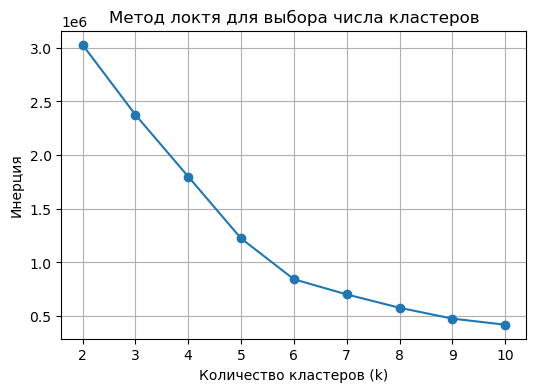

In [64]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Построим график
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Метод локтя для выбора числа кластеров")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Инерция")
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Вывод:
 - График инерции имеет явно выраженный "локоть" при k = 4–5, что означает, 
   что добавление кластеров после этой точки не даёт существенного выигрыша в плотности кластеров.
 - Однако при этом метрика silhouette_score максимальна при k = 7, а это говорит, что разделение на 7 кластеров даёт наилучшую структуру
    — кластеры плотные и хорошо отделены.
 -  Будем использовать 7 кластеров как оптимальный выбор, поскольку silhouette_score учитывает не только плотность, но и качество границ между    кластерами.   

In [66]:
# Кластеризация KMeans
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data["cluster"] = kmeans.fit_predict(X_scaled)
cluster_data.head()

,id,gender,age,education,city,country,personal_coef,product,cost,base_sale,dt,gender_enc,education_enc,cluster
0,0,0,36,среднее,1201,32,0.5072,велосипед горный женский stern mira 20 26,13599,1,7,0,1,2
1,0,0,36,среднее,1201,32,0.5072,стол outventure,1499,0,37,0,1,2
2,0,0,36,среднее,1201,32,0.5072,набор outventure стол 4 стула,4799,0,37,0,1,2
3,4,0,35,среднее,1134,32,0.5072,роликовые коньки детские roces orlando iii,9199,0,0,0,1,2
4,4,0,35,среднее,1134,32,0.5072,шлем fila nrk fun,4999,0,0,0,1,2


In [67]:
# сохраним cluster_data:
cluster_data.to_csv(r"C:\Users\Evgeniya\OneDrive\Desktop\Домашняя\Итоговый проект аналитика\cluster_data.csv", index=False)

## 1. Посчитаем средние значения признаков в каждом кластере:

In [69]:
cluster_data.groupby("cluster")[["age", "personal_coef"]].mean()


,age,personal_coef
cluster,,
0,41.921788,0.430421
1,39.842268,0.464306
2,42.616114,0.507205
3,31.350000,0.339280
4,15.358595,0.272376
5,26.582789,0.468799
6,29.111101,0.558400


In [70]:
# Границы возраста по кластерам
age_stats = cluster_data.groupby("cluster")["age"].agg(["min", "max", "mean"]).round(1).reset_index()
age_stats

,cluster,min,max,mean
0,0,19,77,41.9
1,1,6,77,39.8
2,2,20,77,42.6
3,3,16,50,31.4
4,4,5,22,15.4
5,5,19,66,26.6
6,6,19,74,29.1


## 2. Посмотрим распределение категориальных признаков: 

In [72]:
cluster_data.groupby("cluster")["education"].value_counts(normalize=True).unstack()

education,высшее,среднее
cluster,,
0,0.000710,0.999290
1,0.201890,0.798110
2,0.000093,0.999907
3,0.350000,0.650000
4,0.798875,0.201125
5,1.000000,NaN
6,1.000000,NaN


In [73]:
cluster_data.groupby("cluster")["gender"].value_counts(normalize=True).unstack().round(2)

gender,0,1
cluster,,
0,NaN,1.00
1,0.47,0.53
2,1.00,NaN
3,0.30,0.70
4,0.33,0.67
5,NaN,1.00
6,1.00,NaN


## 3. Какие товары и скидки предпочитают кластеры:

In [75]:
top_products = cluster_data.groupby("cluster")["product"].value_counts().groupby(level=0).head(3).reset_index(name="count")
cluster_data.groupby("cluster")["product"].value_counts().groupby(level=0).head(3)

cluster  product                 
0        брюки мужские demix         2441
         шорты мужские demix         2140
         футболка мужская demix      1732
1        брюки мужские demix          121
         шорты мужские demix          109
         футболка мужская demix        94
2        футболка женская demix      1827
         лиф женский joss            1734
         купальник женский joss      1603
4        брюки мужские demix          153
         шорты мужские nike           146
         шорты мужские demix          144
5        шорты мужские demix          557
         брюки мужские demix          468
         футболка мужская demix       415
6        футболка женская demix       253
         легинсы женские demix        185
         брюки женские outventure     176
Name: count, dtype: int64

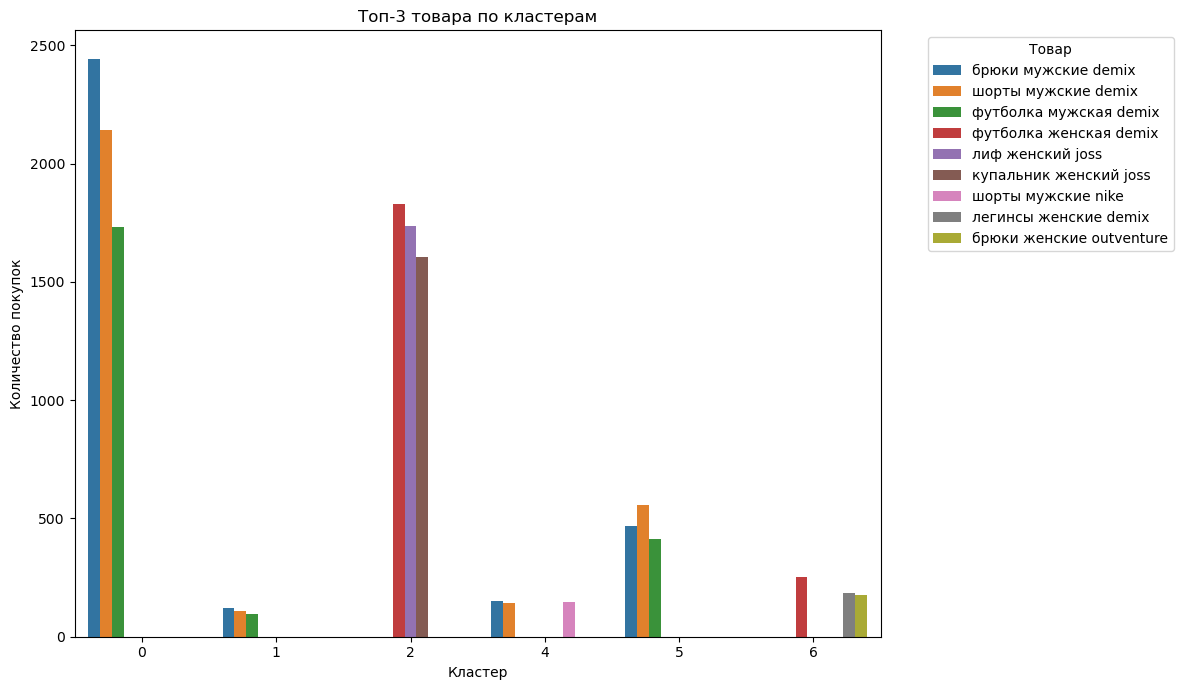

In [76]:
# Визуализация
plt.figure(figsize=(12, 7))
sns.barplot(data=top_products, x="cluster", y="count", hue="product")
plt.title("Топ-3 товара по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество покупок")
plt.legend(title="Товар", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [77]:
cluster_data.groupby("cluster")["base_sale"].mean().round(2)

cluster
0    0.310848
1    0.375228
2    0.409758
3         NaN
4    0.357614
5    0.320364
6    0.392714
Name: base_sale, dtype: object

## 4. Визуализация:

In [79]:
# введем PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
cluster_data["pca1"] = X_pca[:, 0]
cluster_data["pca2"] = X_pca[:, 1]

<Figure size 640x480 with 0 Axes>

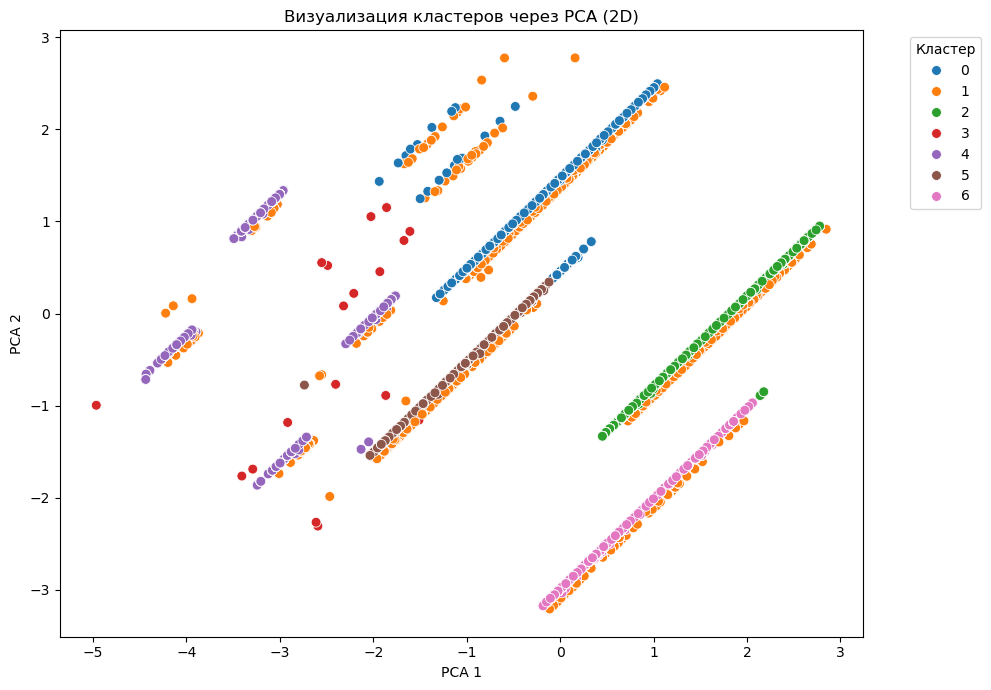

In [80]:
# Построение графика
plt.savefig("pca_clusters.png", dpi=300)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=cluster_data, x="pca1", y="pca2", hue="cluster", palette="tab10", s=50)
plt.title("Визуализация кластеров через PCA (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [81]:
# Таблица характеристик кластеров
summary = cluster_data.groupby("cluster").agg({
    "age": ["min", "max", "mean"],
    "gender_enc": "mean",
    "education_enc": "mean",
    "base_sale": "mean"
}).round(2)
summary

age            gender_enc education_enc base_sale
        min max   mean       mean          mean      mean
cluster                                                  
0        19  77  41.92       1.00          1.00  0.310848
1         6  77  39.84       0.53          0.80  0.375228
2        20  77  42.62       0.00          1.00  0.409758
3        16  50  31.35       0.70          0.65       NaN
4         5  22  15.36       0.67          0.20  0.357614
5        19  66  26.58       1.00          0.00  0.320364
6        19  74  29.11       0.00          0.00  0.392714

In [82]:
# Распределение пола по кластерам
gender_distribution = cluster_data.groupby(["cluster", "gender"]).size().unstack().fillna(0)
gender_distribution["%_0"] = (gender_distribution[0] / gender_distribution.sum(axis=1) * 100).round(1)
gender_distribution["%_1"] = (gender_distribution[1] / gender_distribution.sum(axis=1) * 100).round(1)
gender_distribution

gender,0,1,%_0,%_1
cluster,,,,
0,0.0,274563.0,0.0,100.0
1,8936.0,10109.0,46.9,52.9
2,247430.0,0.0,100.0,0.0
3,6.0,14.0,30.0,28.0
4,12002.0,24443.0,32.9,67.0
5,0.0,68608.0,0.0,100.0
6,34302.0,0.0,100.0,0.0


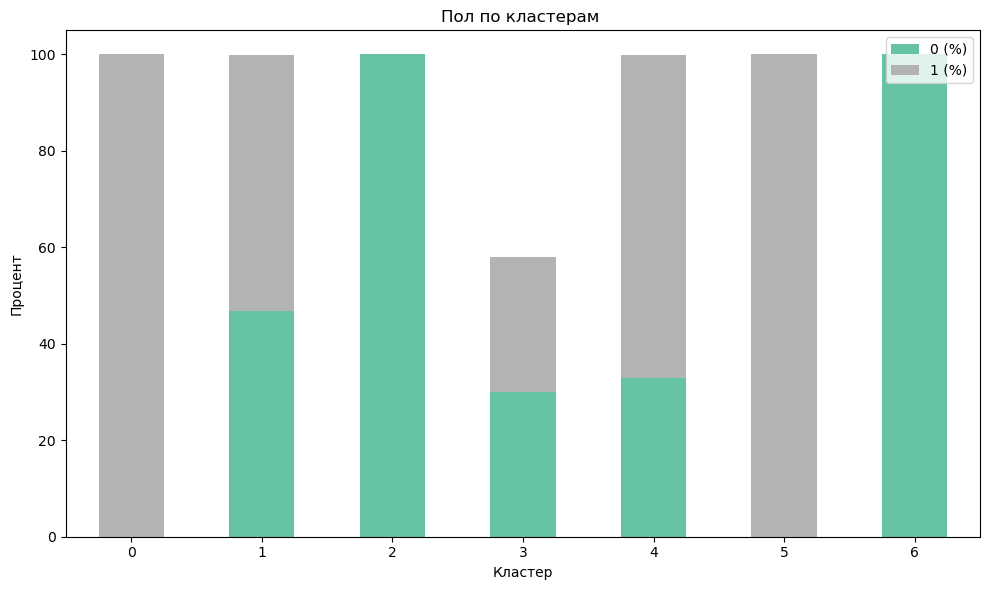

In [83]:
# Визуализация
gender_plot_fixed = gender_distribution[["%_0", "%_1"]]
gender_plot_fixed.columns = ["0 (%)", "1 (%)"]
gender_plot_fixed.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2")
plt.title("Пол по кластерам ")
plt.xlabel("Кластер")
plt.ylabel("Процент")
plt.legend(loc="upper right")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [84]:
# Распределение образования по кластерам
education_distribution = cluster_data.groupby(["cluster", "education"]).size().unstack().fillna(0)
education_distribution_percent = (education_distribution.T / education_distribution.sum(axis=1)).T.round(2) * 100
education_distribution_percent

education,высшее,среднее
cluster,,
0,0.0,100.0
1,20.0,80.0
2,0.0,100.0
3,35.0,65.0
4,80.0,20.0
5,100.0,0.0
6,100.0,0.0


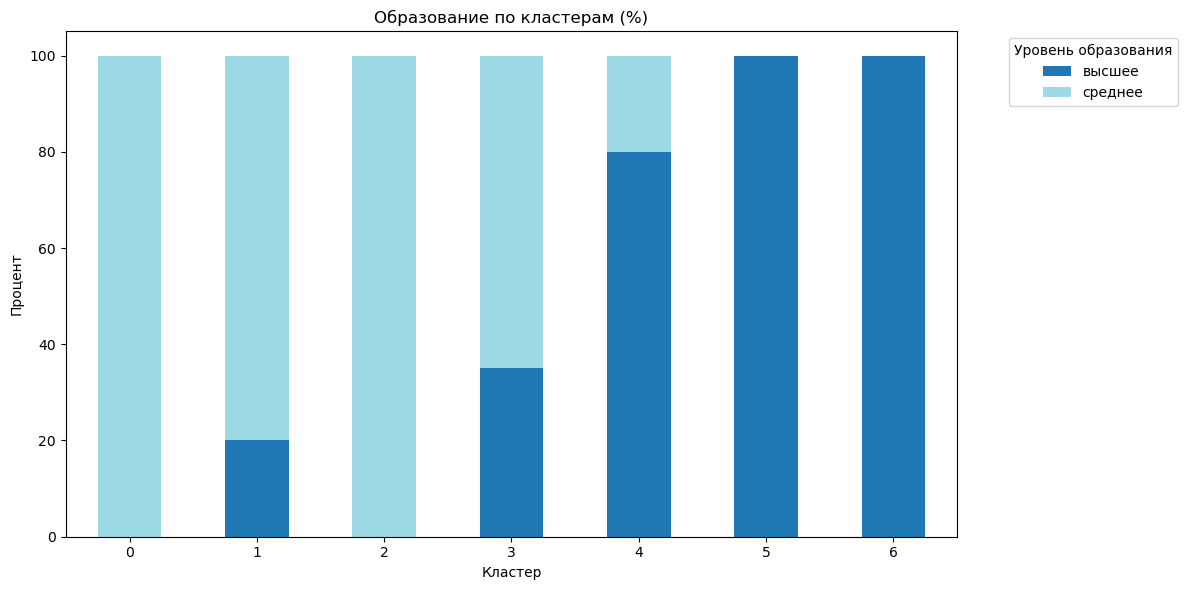

In [85]:
# Визуализация образования
education_distribution_percent.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Образование по кластерам (%)")
plt.xlabel("Кластер")
plt.ylabel("Процент")
plt.legend(title="Уровень образования", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [86]:
# Преобразуем таблицу городов: кластер — топ-3 города
top_3_cities_per_cluster = cluster_data.groupby(["cluster", "city"]).size().reset_index(name="count")
top_3_cities_per_cluster = top_3_cities_per_cluster.sort_values(["cluster", "count"], ascending=[True, False])
top_3_cities = top_3_cities_per_cluster.groupby("cluster")["city"].apply(lambda x: list(x.head(3))).reset_index()
top_3_cities.columns = ["Кластер", "Топ-3 города"]
top_3_cities

,Кластер,Топ-3 города
0,0,"[1134, 1188, 1157]"
1,1,"[9, 34, 2]"
2,2,"[1134, 1188, 1178]"
3,3,"[412, 432, 371]"
4,4,"[1134, 1188, 1157]"
5,5,"[1134, 1188, 1157]"
6,6,"[1134, 1188, 1157]"


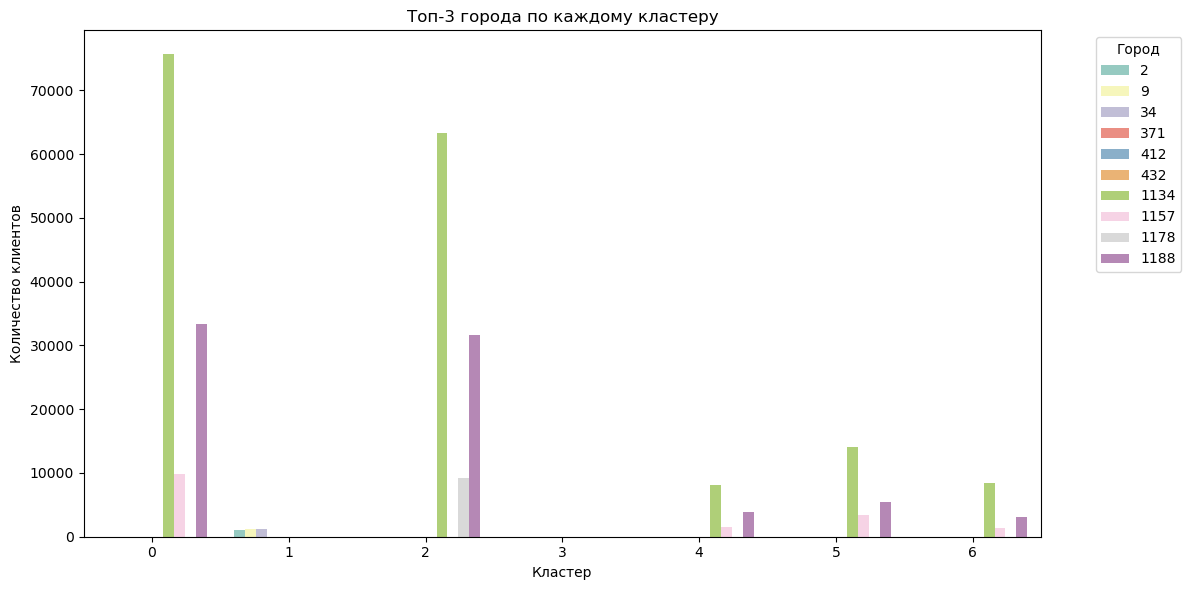

In [87]:
# Визуализация топ-3 городов
plt.figure(figsize=(12, 6))
sns.barplot(data=top_3_cities_per_cluster.groupby("cluster").head(3), 
            x="cluster", y="count", hue="city", palette="Set3")
plt.title("Топ-3 города по каждому кластеру")
plt.xlabel("Кластер")
plt.ylabel("Количество клиентов")
plt.legend(title="Город", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\Evgeniya\AppData\Local\Temp\ipykernel_9412\214178520.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="age", data=cluster_data, palette="Set2")


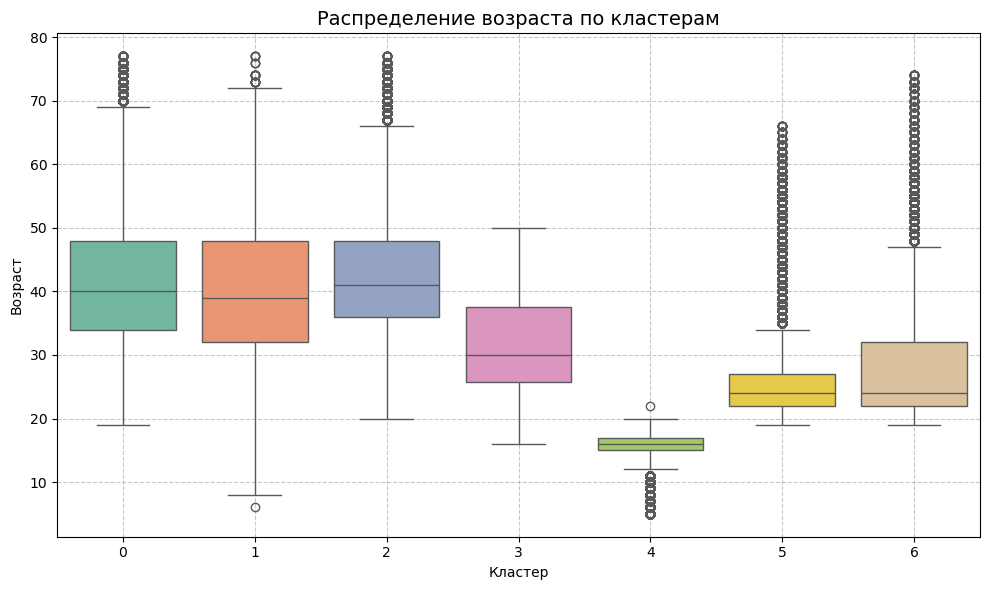

In [88]:
# Boxplot: Возраст по кластерам
plt.figure(figsize=(10, 6))
sns.boxplot(x="cluster", y="age", data=cluster_data, palette="Set2")
plt.title("Распределение возраста по кластерам", fontsize=14)
plt.xlabel("Кластер")
plt.ylabel("Возраст")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("boxplot_age_by_cluster.png")  # сохраняем график
plt.show()

In [89]:
# Посмотрим влиение скидок на покупательское поведение по кластерам:

# Считаем количество и количество скидочных покупок
discount_stats = cluster_data.groupby("cluster")["base_sale"].agg(["count", "sum"]).copy()

# Отфильтруем кластеры без покупок
discount_stats = discount_stats[discount_stats["count"] > 0]

# Расчёт доли скидочных покупок
discount_stats["discount_rate"] = (discount_stats["sum"] / discount_stats["count"] * 100).round(2)
discount_stats["discount_rate"] = discount_stats["discount_rate"].map("{:.2f}".format)
discount_stats

,count,sum,discount_rate
cluster,,,
0,268234,83380,31.08
1,18602,6980,37.52
2,241960,99145,40.98
4,35502,12696,35.76
5,66877,21425,32.04
6,33490,13152,39.27


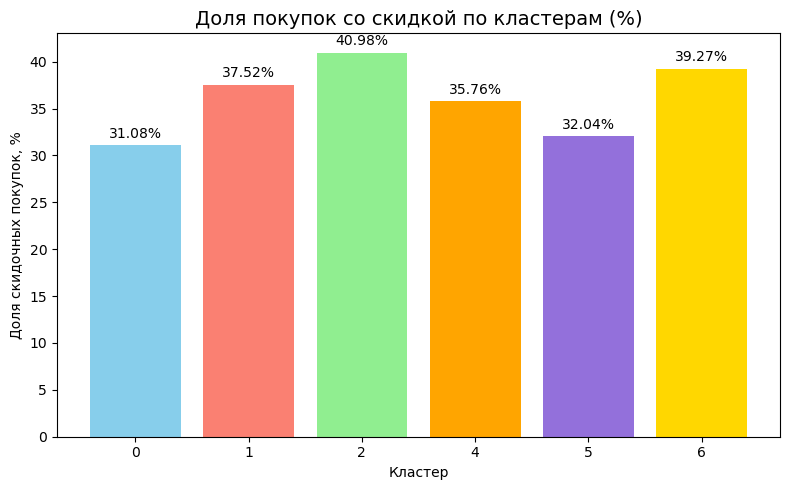

In [90]:
# Посторим график

discount_stats["discount_rate"] = pd.to_numeric(discount_stats["discount_rate"], errors='coerce')

plt.figure(figsize=(8, 5))
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'mediumpurple', 'gold']

# Столбчатая диаграмма 
bars = plt.bar(discount_stats.index.astype(str), discount_stats["discount_rate"].values, color=colors)

plt.title("Доля покупок со скидкой по кластерам (%)", fontsize=14)
plt.xlabel("Кластер")
plt.ylabel("Доля скидочных покупок, %")

# Подписи на каждом столбце
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{discount_stats['discount_rate'].values[i]:.2f}%", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


      |
      |
     |
     |
      |


## если сравнить набор товаров и распределение полов то мы видим, что: 
 - Кластеры 0 и 5 — полностью мужские,
 - Кластеры 2 и 6 — полностью женские,
 - Кластер 1 — наиболее сбалансированный,
 - Кластер 4 — с преобладанием мужчин.



In [93]:
cluster_data

,id,gender,age,education,city,country,personal_coef,product,cost,base_sale,dt,gender_enc,education_enc,cluster,pca1,pca2
0,0,0,36,среднее,1201,32,0.5072,велосипед горный женский stern mira 20 26,13599,1,7,0,1,2,1.100663,-0.689523
1,0,0,36,среднее,1201,32,0.5072,стол outventure,1499,0,37,0,1,2,1.100663,-0.689523
2,0,0,36,среднее,1201,32,0.5072,набор outventure стол 4 стула,4799,0,37,0,1,2,1.100663,-0.689523
3,4,0,35,среднее,1134,32,0.5072,роликовые коньки детские roces orlando iii,9199,0,0,0,1,2,1.064232,-0.731686
4,4,0,35,среднее,1134,32,0.5072,шлем fila nrk fun,4999,0,0,0,1,2,1.064232,-0.731686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680408,135183,1,44,среднее,1134,32,0.4304,None,None,None,None,1,1,0,-0.300816,1.171745
680409,125993,1,46,среднее,1134,32,0.4304,None,None,None,None,1,1,0,-0.219223,1.251803
680410,167019,0,71,среднее,1134,32,0.5072,None,None,None,None,0,1,2,2.532901,0.709365
680411,116355,1,32,среднее,1188,32,0.4304,None,None,None,None,1,1,0,-0.793890,0.693114


In [94]:
cluster_data.isnull().sum()

id                   0
gender               0
age                  0
education            0
city                 0
country              0
personal_coef        0
product          15748
cost             15748
base_sale        15748
dt               15748
gender_enc           0
education_enc        0
cluster              0
pca1                 0
pca2                 0
dtype: int64

In [95]:
cluster_data_cost = cluster_data.dropna(subset=["cost"])

In [96]:
cluster_data_cost.shape

(664665, 16)

In [97]:
# Группируем по кластерам и считаем средний чек
avg_check = cluster_data_cost.groupby("cluster")["cost"].mean().round(2).reset_index()
avg_check.columns = ["Кластер", "Средний чек"]

avg_check

,Кластер,Средний чек
0,0,6437.937801
1,1,5229.633695
2,2,4084.78239
3,4,5582.405893
4,5,6444.735096
5,6,4716.507883


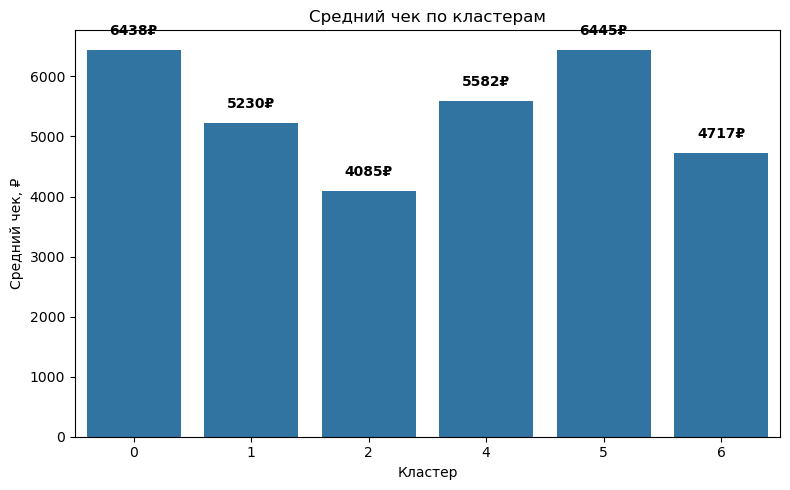

In [98]:
# Построение графика
plt.figure(figsize=(8, 5))
sns.barplot(x="Кластер", y="Средний чек", data=avg_check)

# Подписи над столбцами
for index, row in avg_check.iterrows():
    plt.text(x=index, y=row["Средний чек"] + 200, s=f'{row["Средний чек"]:.0f}₽', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Средний чек по кластерам")
plt.ylabel("Средний чек, ₽")
plt.xlabel("Кластер")
plt.tight_layout()
plt.show()

In [218]:
# Сводная таблица количества клиентов в кластере

# Подсчёт количества клиентов по кластерам
cluster_counts = cluster_data["cluster"].value_counts().sort_index()
cluster_percent = (cluster_counts / cluster_counts.sum() * 100).round(2)

# Формирование сводной таблицы
summary_table = pd.DataFrame({
    "Кластер": cluster_counts.index,
    "Количество клиентов": cluster_counts.values,
    "Процент от общего числа": cluster_percent.values
}).sort_values(by="Процент от общего числа", ascending=False)
print(summary_table.to_string(index=False))


 Кластер  Количество клиентов  Процент от общего числа
       0               274563                    40.35
       2               247430                    36.36
       5                68608                    10.08
       4                36445                     5.36
       6                34302                     5.04
       1                19045                     2.80
       3                   20                     0.00


In [220]:
from IPython.display import display, HTML
display(HTML(summary_table.to_html(index=False)))


Кластер,Количество клиентов,Процент от общего числа
0,274563,40.35
2,247430,36.36
5,68608,10.08
4,36445,5.36
6,34302,5.04
1,19045,2.80
3,20,0.00


| **Кластер** | **Целевая аудитория**                      | **Поведение**                                               | **Топ-3 товара**                                           | **Скидки**                        | **Средний чек** | **Каналы и рекомендации**                                                                 |
|-------------|---------------------------------------------|-------------------------------------------------------------|------------------------------------------------------------|------------------------------------|------------------|--------------------------------------------------------------------------------------------|
| **0**       | Мужчины ~35 лет, среднее образование        | Рациональны, покупают без ориентации на акции               | брюки, шорты, футболки мужские Demix                      | ~31% — наименьшая доля             | ~6 438 ₽         | Ремаркетинг, рекомендации в ЛК, push без скидок, уведомления о наличии и новинках         |
| **1**       | Молодые (28–32), сбалансированный пол       | Предпочитают недорогую мужскую одежду, реагируют на скидки  | брюки, шорты, футболки мужские Demix                      | ~37.5% — высокая чувствительность  | ~5 229 ₽         | Таргетированная реклама, кэшбек, mobile-first маркетинг                                  |
| **2**       | Женщины 38+, преимущественно среднее обр.   | Часто покупают одежду для плавания и отдыха, реагируют на акции | футболки, лифы, купальники женские (Joss, Demix)     | ~41% — наибольшая зависимость      | ~4 084 ₽         | Рекламные баннеры, офлайн-акции, SMS и Viber рассылки                                     |
| **3**       | Малочисленный сегмент, нестабильное поведение | Поведение не выявлено, выбор случайный                      | -                                                          | -                                  | -                | Требует дополнительного анализа или исключения из таргетинга                              |
| **4**       | Мужчины и женщины ~33, преимущественно высшее образование | Чёткий выбор, брендовые предпочтения             | брюки, шорты Nike и Demix                                | ~36% — важны акции на бренды       | ~5 582 ₽         | Ремаркетинг, персональные предложения в кабинете                                          |
| **5**       | Мужчины ~40+, высшее образование            | Покупают качественную одежду, менее чувствительны к скидкам | шорты, брюки, футболки мужские Demix                     | ~32% — скидки важны, но не критичны | ~6 445 ₽         | YouTube/Telegram, спецпредложения по предзаказу                                           |
| **6**       | Женщины 30–40 лет                           | Спорт и досуг, средняя чувствительность к скидке            | футболка, легинсы женские Demix, брюки Outventure        | ~39% — чувствительность высокая    | ~4 716 ₽         | Инфлюенсер-маркетинг, подборки для женщин, каналы для спорта/фитнеса                      |
      |


### **Стратегическое деление по поведенческим признакам**:
 -  **Премиум-кластеры**: 0, 5  
  _Рациональные, платёжеспособные мужчины. Продвижение через спецпредложения, рекомендации и программы лояльност_ 
  _ -  💸 **Чувствительные к цене**: 1, 2, 6  
  _Ориентированы на скидки, распродажи и быструю покупку. Актуальны push, промокоды, соцсет - 
- 👕 **Ценители брендов**: 4  
  _Высокий средний чек, осознанный выбор, важно продвигать через качественный контент и персонализ - ._

- ❓ **Кластер 3**:  
  _Малочисленный и нестабильный. Рекомендуется углублённый анализ или исключение из стратегии._

---

# 5. Построение модели склонности клиента к покупке

## 1. Отбор положительных примеров (реальные покупки)

In [103]:
# Фильтруем клиентов из города 1188
purchase_positive = cluster_data[(cluster_data["city"] == 1188)].copy()

# Удалим пропущенные и ненужные столбцы
purchase_positive = purchase_positive.dropna(subset=["product", "cost"])

# Добавим колонку 'target' = 1 (покупка была)
purchase_positive["target"] = 1
purchase_positive.head()

,id,gender,age,education,city,country,personal_coef,product,cost,base_sale,dt,gender_enc,education_enc,cluster,pca1,pca2,target
10,6,1,52,среднее,1188,32,0.4304,кроссовки для мальчиков geox j sprintye boy,4999,0,1,1,1,0,0.022038,1.493698,1
11,6,1,52,среднее,1188,32,0.4304,кеды мужские reebok royal complete cln2,4799,1,3,1,1,0,0.022038,1.493698,1
12,6,1,52,среднее,1188,32,0.4304,футболка мужская kappa authentic core,999,0,8,1,1,0,0.022038,1.493698,1
13,6,1,52,среднее,1188,32,0.4304,бейсболка детская nike futura mash up,1119,1,11,1,1,0,0.022038,1.493698,1
14,6,1,52,среднее,1188,32,0.4304,носки детские demix 2 пары,299,0,11,1,1,0,0.022038,1.493698,1


In [104]:
purchase_positive.isnull().sum()

id               0
gender           0
age              0
education        0
city             0
country          0
personal_coef    0
product          0
cost             0
base_sale        0
dt               0
gender_enc       0
education_enc    0
cluster          0
pca1             0
pca2             0
target           0
dtype: int64

## 2. Формирование отрицательных примеров

In [106]:
# Все уникальные товары
unique_products = cluster_data["product"].dropna().unique()
unique_products

array(['велосипед горный женский stern mira 20 26', 'стол outventure',
       'набор outventure стол  4 стула', ...,
       'батончик протеиновый forsio 40 г 30 шт',
       'футболка мужская reebok united by fitness',
       'бутсы мужские adidas predator 193 tf'], dtype=object)

In [107]:
# Сформируем отрицательные примеры
negatives = []

for _, row in purchase_positive.iterrows():
    for _ in range(2):  # два отрицательных примера на одного клиента
        random_product = random.choice(unique_products)
        # Если не покупал этот товар
        if random_product not in purchase_positive[purchase_positive["id"] == row["id"]]["product"].values:
            negatives.append({
                "id": row["id"],
                "gender_enc": row["gender_enc"],
                "age": row["age"],
                "education_enc": row["education_enc"],
                "personal_coef": row["personal_coef"],
                "product": random_product,
                "target": 0})

purchase_negative = pd.DataFrame(negatives)
purchase_negative.head()

,id,gender_enc,age,education_enc,personal_coef,product,target
0,6,1,52,1,0.4304,поло мужское babolat perf,0
1,6,1,52,1,0.4304,надставка для хоккейных клюшек madguy,0
2,6,1,52,1,0.4304,кроссовки мужские gsd castle,0
3,6,1,52,1,0.4304,велосипед городской trek fx 3 disc 700c 2022,0
4,6,1,52,1,0.4304,футболка мужская the north face lightning,0


## 3. Объединяем покупки и не покупки

In [109]:
# Подготовим положительные
features_pos = purchase_positive[["id", "gender_enc", "age", "education_enc", "personal_coef", "product", "target"]]

# Объединяем
df_model = pd.concat([features_pos, purchase_negative], ignore_index=True)
df_model.head()

,id,gender_enc,age,education_enc,personal_coef,product,target
0,6,1,52,1,0.4304,кроссовки для мальчиков geox j sprintye boy,1
1,6,1,52,1,0.4304,кеды мужские reebok royal complete cln2,1
2,6,1,52,1,0.4304,футболка мужская kappa authentic core,1
3,6,1,52,1,0.4304,бейсболка детская nike futura mash up,1
4,6,1,52,1,0.4304,носки детские demix 2 пары,1


In [110]:
df_model.shape

(226389, 7)

## 4. Преобразование и обучение модели

In [112]:
le_product = LabelEncoder()
df_model["product_enc"] = le_product.fit_transform(df_model["product"])

In [113]:
X = df_model[["gender_enc", "age", "education_enc", "personal_coef", "product_enc"]]
y = df_model["target"]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Проверим качество
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     45267
           1       0.58      0.60      0.59     22650

    accuracy                           0.72     67917
   macro avg       0.69      0.69      0.69     67917
weighted avg       0.72      0.72      0.72     67917



## Интерпретация:
Модель достаточно хорошо распознаёт тех, кто не покупает товар (класс 0) — точность 80%.

Для класса 1 (тех, кто покупает товар) модель работает удовлетворительно, но не идеально:

F1-score = 0.59 — это компромисс между точностью и полнотой.

Recall (60%) — модель ловит 60% потенциальных покупателей, что может быть приемлемо для маркетинга.

Общая точность — 72%, что для задачи рекомендации товаров — вполне рабочий результат.

## Выводы и рекомендации:

 - Модель можно использовать для приоритизации рассылок и товарных предложений: запускать кампании только на клиентов с высокой вероятностью покупки.

 - Чтобы улучшить качество:
                            учесть повторные покупки,

                            добавить данные о прошлых реакциях на акции (например, по base_sale),

                            использовать признаки категорий товара или бренда.

F1-score в районе 0.59 — это хороший старт для рекомендательной модели без поведенческих меток (например, кликов, просмотров).